## Analyse Adjektivanteile der Gedichte

1. Hypothesen
- **H0**: Es gibt zwischen den beiden Subsamples (M/W) **keinen signifikanten Unterschied** beim Anteil der Adjektive.
- **H1**: Es gibt zwischen den beiden Subsamples (M/W) **einen signifikanten Unterschied** beim Anteil der Adjektive.
    - &rarr; "Frauen schreiben detailliertere Gedichte (= mit mehr Adjektiven) als Männer."

In [1]:
import os
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns

from scipy.stats import ttest_ind, shapiro, mannwhitneyu

/Users/jule/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Daten vorbereiten

- Dictionary mit absoluten Adjektivhäufigkeiten
- Dictionary mit relativen Adjektivhäufigkeiten

In [2]:
path = r'corpus_finished'

#Load German tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('de_core_news_md')

def extract_adjectives(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'ADJ']

#Initialize data structures
adjectives_gender = {'m': Counter(), 'w': Counter()}
adjective_ratios_gender = {'m': [], 'w': []}

#Iterate over .json files
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            gender = data['gender']
            poem_text = ' '.join(line['text'] for line in data['poem'].values())
            adjectives = extract_adjectives(poem_text)
            ratio = len(adjectives) / len(poem_text.split())
            adjectives_gender[gender].update(adjectives)
            adjective_ratios_gender[gender].append(ratio)

print(len(adjective_ratios_gender['m']))
print(len(adjective_ratios_gender['w']))

135
96


3. Deskriptive Statistik
- Durchschnitt (Mittelwert)
- Minimum und Maximum
- Standardabweichung der Verslängen für jedes Subsample?

In [3]:
#Calculate average adjective ratios for each gender
average_ratios_gender = {gender: sum(ratios) / len(ratios) for gender, ratios in adjective_ratios_gender.items()}

all_genders = sorted(list(average_ratios_gender.keys()))

#Print average, minimum, and maximum adjective ratio for each gender
for gender in all_genders:
    all_ratios = adjective_ratios_gender[gender]
    print(f'Gender: {gender}')
    print('average relative adjective ratio:', sum(all_ratios) / len(all_ratios))
    print('standard deviation:', statistics.stdev(all_ratios))
    print('Minimum relative adjective ratio:', min(all_ratios))
    print('Maximum relative adjective ratio:', max(all_ratios), '\n')

#Print the 10 most common adjectives for each gender
for gender in all_genders:
    print(f'Gender: {gender}')
    print('10 most common adjectives:', adjectives_gender[gender].most_common(10), '\n')

Gender: m
average relative adjective ratio: 0.035786160280130916
standard deviation: 0.02734283615782431
Minimum relative adjective ratio: 0.0
Maximum relative adjective ratio: 0.13978494623655913 

Gender: w
average relative adjective ratio: 0.045609867161218454
standard deviation: 0.03614854598032378
Minimum relative adjective ratio: 0.0
Maximum relative adjective ratio: 0.16393442622950818 

Gender: m
10 most common adjectives: [('andere', 7), ('weißen', 7), ('ganze', 6), ('alte', 6), ('kleine', 6), ('grünen', 6), ('letzten', 6), ('kleinen', 5), ('große', 5), ('ersten', 5)] 

Gender: w
10 most common adjectives: [('hellen', 7), ('eigenen', 6), ('große', 5), ('kleine', 5), ('andere', 5), ('alten', 5), ('letzten', 4), ('rote', 4), ('10.', 4), ('schwarzen', 4)] 



4. Statistischer Test

**Teststatistik: t-Test?**
Vorausssetzung ist Normalverteilung, also Normalverteilung der Tokenfrequency testen:

In [4]:
# Funktion zum Durchführen des Shapiro-Wilk-Tests und zur Interpretation der Ergebnisse
def test_normality(data, sample_name):
    stat, p_value = shapiro(data)
    alpha = 0.05  # Signifikanzniveau
    print(f"Shapiro-Wilk-Test für {sample_name}:")
    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value > alpha:
        print(f"Die Adjektivfrequenzen für {sample_name} sind normalverteilt.")
    else:
        print(f"Die Adjektivfrequenzen für {sample_name} sind nicht normalverteilt.")

# Durchführung des Tests für beide Subsamples
test_normality(adjective_ratios_gender['m'], "Sample M")
test_normality(adjective_ratios_gender['w'], "Sample W")

Shapiro-Wilk-Test für Sample M:
Teststatistik: 0.9206070303916931
p-Wert: 7.563403983112948e-07
Die Adjektivfrequenzen für Sample M sind nicht normalverteilt.
Shapiro-Wilk-Test für Sample W:
Teststatistik: 0.9200623631477356
p-Wert: 2.0520003090496175e-05
Die Adjektivfrequenzen für Sample W sind nicht normalverteilt.


**Versuch: t-Test**
- Begründung: eine unschöne, aber mögliche Option, weil t-Test relativ robust ist (siehe Stefanowitsch, Kap. 6, S. 197)

In [5]:
# Perform a t-test to compare the means of the two groups
t_stat, p_val = ttest_ind(adjective_ratios_gender['m'], adjective_ratios_gender['w'])

print('T-statistic:', t_stat)
print('p-value:', p_val)

T-statistic: -2.351012875014396
p-value: 0.019571426992995404


## &rarr; **Mann-Whitney-U-Test** (= Test für Ordinaldaten)
- Ausweichmöglichkeit, wenn t-Test wegen nicht normalverteilten Daten nicht sinnvoll ist (siehe Stefanowitsch, Kap. 6, S. 198)

In [6]:
u_stat, p_val = mannwhitneyu(adjective_ratios_gender['m'], adjective_ratios_gender['w'], alternative='two-sided')

print('Mann-Whitney U-Statistik:', u_stat)
print('p-Wert:', p_val)

Mann-Whitney U-Statistik: 5591.5
p-Wert: 0.07593075311331557


In [7]:
n1 = len(adjective_ratios_gender['m'])
n2 = len(adjective_ratios_gender['w'])
effect_size = np.sqrt(u_stat / (n1 * n2))

print("Effektstärke (Cramer's V):", effect_size)

Effektstärke (Cramer's V): 0.6568431328974734


5. Visualisierungen

(array([13.,  5., 10., 14., 12.,  8., 12., 11.,  5., 10.,  5.,  2.,  5.,
         2.,  0.,  5.,  6.,  0.,  3.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.        , 0.0046595 , 0.009319  , 0.01397849, 0.01863799,
        0.02329749, 0.02795699, 0.03261649, 0.03727599, 0.04193548,
        0.04659498, 0.05125448, 0.05591398, 0.06057348, 0.06523297,
        0.06989247, 0.07455197, 0.07921147, 0.08387097, 0.08853047,
        0.09318996, 0.09784946, 0.10250896, 0.10716846, 0.11182796,
        0.11648746, 0.12114695, 0.12580645, 0.13046595, 0.13512545,
        0.13978495]),
 <BarContainer object of 30 artists>)

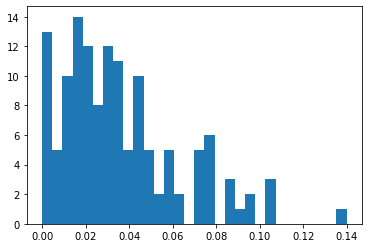

In [8]:
plt.hist(adjective_ratios_gender['m'], bins=30)

(array([ 9.,  5.,  7., 11.,  5.,  4.,  5., 11.,  3.,  3.,  5.,  1.,  5.,
         7.,  2.,  1.,  1.,  3.,  0.,  0.,  3.,  0.,  2.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.]),
 array([0.        , 0.00546448, 0.01092896, 0.01639344, 0.02185792,
        0.0273224 , 0.03278689, 0.03825137, 0.04371585, 0.04918033,
        0.05464481, 0.06010929, 0.06557377, 0.07103825, 0.07650273,
        0.08196721, 0.08743169, 0.09289617, 0.09836066, 0.10382514,
        0.10928962, 0.1147541 , 0.12021858, 0.12568306, 0.13114754,
        0.13661202, 0.1420765 , 0.14754098, 0.15300546, 0.15846995,
        0.16393443]),
 <BarContainer object of 30 artists>)

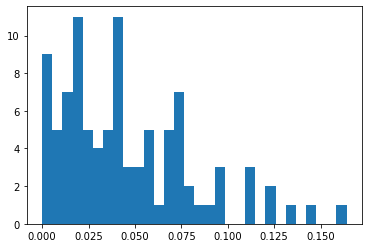

In [9]:
plt.hist(adjective_ratios_gender['w'], bins=30)

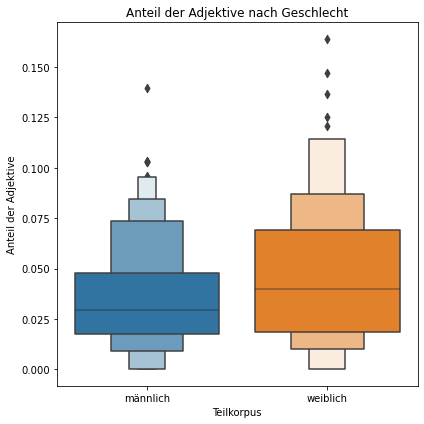

In [10]:
# Zusammenführen der Daten in einem DataFrame für seaborn
import pandas as pd
data = pd.DataFrame({
    "Geschlecht": ["männlich"] * len(adjective_ratios_gender['m']) + ["weiblich"] * len(adjective_ratios_gender['w']),
    "Adjektivanteil": adjective_ratios_gender['m'] + adjective_ratios_gender['w']
})

# Boxplot erstellen
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxenplot(x="Geschlecht", y="Adjektivanteil", data=data, ax=ax)

# Label und Titel bestimmen
plt.xlabel("Teilkorpus")
plt.ylabel("Anteil der Adjektive")
plt.title("Anteil der Adjektive nach Geschlecht")


# Plot anzeigen
plt.tight_layout()
plt.show()